# Welcome to the cooltools pileups notebook!

Content:

- Data download
- Reading the information about the genome
- CTCF on-diagonal pipeup
- Inspect examples (on its way)
- CTCF off-diagonal pileup (on its way)

In [9]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# import libraries for biological data analysis
import cooler
import bioframe

import cooltools
from cooltools import snipping
import cooltools.expected

### Data download

In [3]:
# Print available datasets for download
cooltools.print_available_datasets()

Available datasets:
1) HFF_MicroC : Micro-C data from HFF human cells for two chromosomes (hg38) in a multi-resolution mcool format. 
  Downloaded from https://osf.io/3h9js/download 
  Stored as test.mcool
2) HFF_CTCF_fc : ChIP-Seq fold change over input with CTCF antibodies in HFF cells (hg38). Downloaded from ENCODE ENCSR000DWQ, ENCFF761RHS.bigWig file 
  Downloaded from https://osf.io/w92u3/download 
  Stored as test_CTCF.bigWig
3) HFF_CTCF_binding : Binding sites called from CTCF ChIP-Seq peaks for HFF cells (hg38). Peaks are from ENCODE ENCSR000DWQ, ENCFF498QCT.bed file. The motifs are called with gimmemotifs (options --nreport 1 --cutoff 0), with JASPAR pwm MA0139. 
  Downloaded from https://osf.io/c9pwe/download 
  Stored as test_CTCF.bed.gz


In [4]:
# Downloading test data for pileups
# cache = True will doanload the data only if it was not previously downloaded
# data_dir="./" will force download to the current directory
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
ctcf_peaks_file = cooltools.download_data("HFF_CTCF_binding", cache=True, data_dir='./')

downloading: https://osf.io/3h9js/download as ./test.mcool
downloading: https://osf.io/c9pwe/download as ./test_CTCF.bed.gz


### Reading information about the genome

When constructing an average plot, the pileup function needs to know the information about the genomic regions. 

How the information of the regions will be used in the pileup? 

- First, the pileup uses regions for parallelization of snipping. Different genomic regions are loaded simultaneously by different processes, and the snipping can be done in parallel. 
- Second, one particular type of pileup, observed over expected pileup, requires calculating expected interactions before snipping (P(s), in other words). Typically, you want to calculate each chromosome arm's expected interactions separately and not to include the interactions between chromosome arms (that might be affected by strong insulation of centromeres or Rabl configuration). 

For species that do not have information on chromosome arms (e.g., mouse), you may use full chromosomes instead. 

In [5]:
# Open cool file with Micro-C data:
clr = cooler.Cooler('./test.mcool::/resolutions/1000')
# Set up selected data resolution:
resolution = 1000

In [6]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.split(hg38_chromsizes, hg38_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_chromsizes = hg38_chromsizes.set_index("chrom").loc[clr.chromnames].reset_index() 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg38_arms = bioframe.parse_regions(hg38_arms)

### Reading features for pileups

As input for the pileup you need genomic **features** that will be used for centering the **snippets**. You will use positions of CTCF motifs in the peaks as features. 

In [19]:
# Read CTCF peaks data and select only chromosomes present in cooler:
ctcf = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')
ctcf.head()

,chrom,start,end,name,score,strand
17271,chr17,118485,118504,MA0139.1_CTCF_human,12.384042,-
17272,chr17,144002,144021,MA0139.1_CTCF_human,11.542617,+
17273,chr17,163676,163695,MA0139.1_CTCF_human,5.294219,-
17274,chr17,164711,164730,MA0139.1_CTCF_human,11.889376,+
17275,chr17,309416,309435,MA0139.1_CTCF_human,7.879575,-


In [20]:
# select the top 500 CTCF sites by the strength of binding
sites = ctcf.sort_values('score', ascending=False).iloc[:500]
sites.head()

,chrom,start,end,name,score,strand
25503,chr2,231612720,231612739,MA0139.1_CTCF_human,17.565931,+
19151,chr17,75905145,75905164,MA0139.1_CTCF_human,17.527591,+
19048,chr17,73370058,73370077,MA0139.1_CTCF_human,17.520560,-
17845,chr17,27760209,27760228,MA0139.1_CTCF_human,17.448366,+
17408,chr17,4413369,4413388,MA0139.1_CTCF_human,17.382937,-


Let's take a look at the distribution of scores and the top 500 selected ones: 

Text(0.5, 1.0, 'Histogram of CTCF motifs scores')

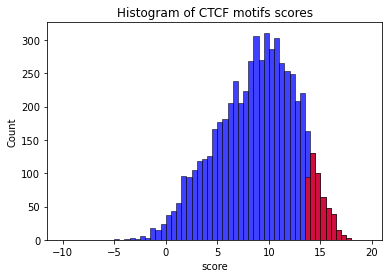

In [28]:
# TODO: Add CTCF peak prominence from MACS output instead, visualize thecorrelation between them both
sns.histplot(ctcf.score, color='blue', bins=np.arange(-10,20,0.5))
sns.histplot(sites.score, color='red', bins=np.arange(-10,20,0.5))
plt.title('Histogram of CTCF motifs scores')

## On-diagonal pileup

On-diagonal pileup is the simplest, you need the positions of **features** (middlepoints of CTCF motifs) and the size of flanks aroung each motif. cooltools will create a snippet of Hi-C map for each feature. Then you can combine them into a single 2D pileup. 

In [29]:
# Converting dataframe with features to format digestible by cooltools
# This will be changed in the future and substituted with nicer API
flank = 100000
windows = snipping.make_bin_aligned_windows(
    resolution, 
    sites['chrom'], 
    (sites['start'] + sites['end'])//2,
    flank_bp=flank)
windows['strand'] = sites['strand']

# Assign genomic regions to windows:
supports = hg38_arms[['chrom', 'start', 'end']].values
windows = snipping.assign_regions(windows, supports)
windows.head()

,chrom,start,end,lo,hi,strand,region
25503,chr2,231512000,231713000,231512,231713,+,chr2:93139351-242193529
19151,chr17,75805000,76006000,75805,76006,+,chr17:24714921-83257441
19048,chr17,73270000,73471000,73270,73471,-,chr17:24714921-83257441
17845,chr17,27660000,27861000,27660,27861,+,chr17:24714921-83257441
17408,chr17,4313000,4514000,4313,4514,-,chr17:0-24714921


In [30]:
# create the snipper object, which can be re-defined by user. 
# this will be changed in future
snipper = cooltools.snipping.CoolerSnipper(clr)

stack = cooltools.snipping.pileup(
        windows, 
        snipper.select, 
        snipper.snip) 

stack[np.isinf(stack)] = np.nan

# mirror reflect snippets whose feature is on the opposite strand
mask = np.array(windows.strand == '-', dtype=bool)
stack[:, :, mask] = stack[::-1, ::-1, mask]
    
mtx = np.nanmean(stack, axis=2)

Text(0, 0.5, 'relative position, kbp')

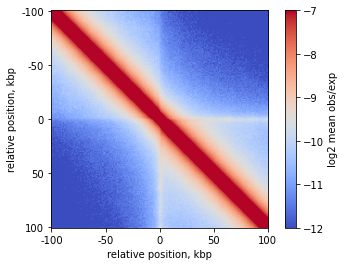

In [36]:
plt.imshow(
    np.log2(mtx),
    vmax = -7,
    vmin = -12,
    cmap='coolwarm')
plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')